## Tesla Stock Classification Model

### Importing libraries and packaging

In [52]:
# Import libraries and packages
import numpy as np
import pandas as pd
from datetime import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tseries.offsets import BDay  # Business day offset
import ta
from scipy.stats import zscore

import yfinance as yf
from fredapi import Fred


#### Importing Datasets

In [2]:
# Importing features from Yahoo Finance
features = ['TSLA', # Tesla Stock Price
            '^VIX', # Volatility Index
            '^GSPC', # S&P 500 Index
            '^DJI', # Nasdaq Composite Index
            'BTC-USD', # Bitcoin Price
            '^TNX',  # 10-Year Treasury Yield
            'CL=F',  # Crude Oil Futures
            'BZ=F',  # Brent Oil Futures
            '^DJI',  # Dow Jones Industrial Average
            ]

# Getting Tesla Stock Price & Features from Yahoo Finance
yahoo_data = yf.download(features, start='2016-01-01', end=(datetime.today().strftime('%Y-%m-%d')))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


In [3]:
# Importing Tesla Key Financial Data
tsla_financial= yf.Ticker("TSLA")
financials = tsla_financial.financials.T
balance_sheet = tsla_financial.balance_sheet.T
cashflow = tsla_financial.cashflow.T

In [4]:
# Importing features from FRED
# Set up FRED API Key
FRED_API_KEY = "94c4c85e75d751a806c45444ead0f393"  # Replace with your FRED API key
fred = Fred(api_key=FRED_API_KEY)

# Define Economic Indicators & Their Corrected FRED Codes
fred_series = {
    "CPI": "CPIAUCSL",  # Consumer Price Index
    "PPI": "PPIACO",  # Producer Price Index
    "Unemployment_Rate": "UNRATE",
    "Consumer_Sentiment": "UMCSENT",
    "Federal_Funds_Rate": "FEDFUNDS",
    "Durable_Goods_Orders": "DGORDER",  # Corrected
    "Industrial_Production_Index": "INDPRO",  # Corrected
    "Labor_Force_Participation": "CIVPART",  # Corrected
    "Job_Openings_JOLTS": "JTSJOL",  # Corrected
}

# Define Date Range for 7 Years
start_date = "2016-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch Data from FRED
df_list = []
for feature, series in fred_series.items():
    data = fred.get_series(series, start_date, end_date)
    df = pd.DataFrame(data, columns=[feature])
    df.index = pd.to_datetime(df.index)  # Ensure datetime index
    df_list.append(df)

# Merge All Data into a Single DataFrame
economic_data = pd.concat(df_list, axis=1)


### EDA - Importing, Cleaning and Merging Data

In [5]:
yahoo_data.tail()

Price              Close                                                  \
Ticker           BTC-USD       BZ=F       CL=F        TSLA          ^DJI   
Date                                                                       
2025-03-04  87222.195312  71.040001  68.260002  272.040009  42520.988281   
2025-03-05  90623.562500  69.300003  66.309998  279.100006  43006.589844   
2025-03-06  89961.726562  69.459999  66.360001  263.450012  42579.078125   
2025-03-07  86742.671875  70.379997  67.050003  262.670013  42801.718750   
2025-03-08  86154.593750        NaN        NaN         NaN           NaN   

Price                                              High             ...  \
Ticker            ^GSPC   ^TNX       ^VIX       BTC-USD       BZ=F  ...   
Date                                                                ...   
2025-03-04  5778.149902  4.210  23.510000  88911.273438  71.459999  ...   
2025-03-05  5842.629883  4.265  21.930000  90998.242188  71.160004  ...   
2025-03-06  5738.520020  4.286  24.870001  92804.937500  69.879997  ...   
2025-03-07  5770.200195  4.317  23.370001  91191.046875  71.379997  ...   
2025-03-08          NaN    NaN        NaN  86847.265625        NaN  ...   

Price        Open                  Volume                                  \
Ticker       ^TNX       ^VIX      BTC-USD     BZ=F      CL=F         TSLA   
Date                                                                        
2025-03-04  4.134  22.959999  68095241474  58867.0  386750.0  126706600.0   
2025-03-05  4.231  23.030001  50498988027  51721.0  382493.0   94042900.0   
2025-03-06  4.277  22.600000  47749810486  49024.0  341632.0   98451600.0   
2025-03-07  4.251  24.850000  65945677657  45789.0  300908.0  102193000.0   
2025-03-08    NaN        NaN  18206118081      NaN       NaN          NaN   

Price                                            
Ticker             ^DJI         ^GSPC ^TNX ^VIX  
Date                                             
2025-03-04  815780000.0  6.138110e+09  0.0  0.0  
2025-03-05  582350000.0  5.285970e+09  0.0  0.0  
2025-03-06  643880000.0  5.165080e+09  0.0  0.0  
2025-03-07  763440000.0  5.705140e+09  0.0  0.0  
2025-03-08          NaN           NaN  NaN  NaN  

[5 rows x 40 columns]

In [6]:
# Flatten multi-level column names in Yahoo Data
yahoo_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in yahoo_data.columns]
yahoo_data.head()

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,...,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,434.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,436.246002,NaN,...,NaN,NaN,36278900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,433.437988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,436.062012,NaN,...,NaN,NaN,30096600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433.743011,NaN,...,NaN,NaN,39633800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,37.220001,36.759998,14.894000,17148.939453,2012.660034,2.245,20.700001,434.516998,38.990002,...,2.230,22.48,38477500,41288.0,431985.0,102406500.0,148060000.0,4.304880e+09,0.0,0.0
2016-01-05,431.959991,36.419998,35.970001,14.895333,17158.660156,2016.709961,2.248,19.340000,434.182007,37.570000,...,2.243,20.75,34522600,29327.0,410131.0,47802000.0,105750000.0,3.706620e+09,0.0,0.0


In [7]:
# Drop all rows where Tesla's 'Close' price is missing
# Removes BTC weekend's price
yahoo_data = yahoo_data.dropna(subset=[('Close_TSLA')])
yahoo_data.head()

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,...,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,433.091003,37.220001,36.759998,14.894000,17148.939453,2012.660034,2.245,20.700001,434.516998,38.990002,...,2.230,22.480000,38477500,41288.0,431985.0,102406500.0,148060000.0,4.304880e+09,0.0,0.0
2016-01-05,431.959991,36.419998,35.970001,14.895333,17158.660156,2016.709961,2.248,19.340000,434.182007,37.570000,...,2.243,20.750000,34522600,29327.0,410131.0,47802000.0,105750000.0,3.706620e+09,0.0,0.0
2016-01-06,429.105011,34.230000,33.970001,14.602667,16906.509766,1990.260010,2.177,20.590000,431.855988,36.720001,...,2.191,21.670000,34042500,43019.0,563811.0,56686500.0,120250000.0,4.336660e+09,0.0,0.0
2016-01-07,458.048004,33.750000,33.270000,14.376667,16514.099609,1943.089966,2.153,24.990000,458.765991,34.730000,...,2.163,23.219999,87562200,44381.0,617409.0,53314500.0,176240000.0,5.076590e+09,0.0,0.0
2016-01-08,453.230011,33.549999,33.160000,14.066667,16346.450195,1922.030029,2.130,27.010000,462.933990,34.730000,...,2.163,22.959999,56993000,39985.0,596496.0,54421500.0,141850000.0,4.664940e+09,0.0,0.0


In [8]:
# Getting full date range of weekdays
full_date_range = pd.date_range(start=yahoo_data.index.min(), end=yahoo_data.index.max(), freq=BDay())  # BDay excludes weekends

# Find missing dates
missing_dates = full_date_range.difference(yahoo_data.index)
missing_dates


DatetimeIndex(['2016-01-18', '2016-02-15', '2016-03-25', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-04-14',
               '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-03-30', '2018-05-28', '2018-07-04', '2018-09-03',
               '2018-11-22', '2018-12-05', '2018-12-25', '2019-01-01',
               '2019-01-21', '2019-02-18', '2019-04-19', '2019-05-27',
               '2019-07-04', '2019-09-02', '2019-11-28', '2019-12-25',
               '2020-01-01', '2020-01-20', '2020-02-17', '2020-04-10',
               '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-26',
               '2020-12-25', '2021-01-01', '2021-01-18', '2021-02-15',
               '2021-04-02', '2021-05-31', '2021-07-05', '2021-09-06',
               '2021-11-25', '2021-12-24', '2022-01-17', '2022-02-21',
      

Missing Dates correspond with US Stock Market Holidays.

In [9]:
# Fill with previous Trading Day's Data
yahoo_data = yahoo_data.asfreq('B').ffill()  # 'B' = Weekdays

In [10]:
# Rechecking missing dates
missing_dates = full_date_range.difference(yahoo_data.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='B')

No dates are missing data now in Yahoo Finance Dataset.

In [11]:
yahoo_data.dtypes

Close_BTC-USD     float64
Close_BZ=F        float64
Close_CL=F        float64
Close_TSLA        float64
Close_^DJI        float64
Close_^GSPC       float64
Close_^TNX        float64
Close_^VIX        float64
High_BTC-USD      float64
High_BZ=F         float64
High_CL=F         float64
High_TSLA         float64
High_^DJI         float64
High_^GSPC        float64
High_^TNX         float64
High_^VIX         float64
Low_BTC-USD       float64
Low_BZ=F          float64
Low_CL=F          float64
Low_TSLA          float64
Low_^DJI          float64
Low_^GSPC         float64
Low_^TNX          float64
Low_^VIX          float64
Open_BTC-USD      float64
Open_BZ=F         float64
Open_CL=F         float64
Open_TSLA         float64
Open_^DJI         float64
Open_^GSPC        float64
Open_^TNX         float64
Open_^VIX         float64
Volume_BTC-USD    float64
Volume_BZ=F       float64
Volume_CL=F       float64
Volume_TSLA       float64
Volume_^DJI       float64
Volume_^GSPC      float64
Volume_^TNX 

In [12]:
# Change the Date index to a column
yahoo_data.reset_index(inplace=True)
yahoo_data.head()

,Date,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,...,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX
0,2016-01-04,433.091003,37.220001,36.759998,14.894000,17148.939453,2012.660034,2.245,20.700001,434.516998,...,2.230,22.480000,38477500.0,41288.0,431985.0,102406500.0,148060000.0,4.304880e+09,0.0,0.0
1,2016-01-05,431.959991,36.419998,35.970001,14.895333,17158.660156,2016.709961,2.248,19.340000,434.182007,...,2.243,20.750000,34522600.0,29327.0,410131.0,47802000.0,105750000.0,3.706620e+09,0.0,0.0
2,2016-01-06,429.105011,34.230000,33.970001,14.602667,16906.509766,1990.260010,2.177,20.590000,431.855988,...,2.191,21.670000,34042500.0,43019.0,563811.0,56686500.0,120250000.0,4.336660e+09,0.0,0.0
3,2016-01-07,458.048004,33.750000,33.270000,14.376667,16514.099609,1943.089966,2.153,24.990000,458.765991,...,2.163,23.219999,87562200.0,44381.0,617409.0,53314500.0,176240000.0,5.076590e+09,0.0,0.0
4,2016-01-08,453.230011,33.549999,33.160000,14.066667,16346.450195,1922.030029,2.130,27.010000,462.933990,...,2.163,22.959999,56993000.0,39985.0,596496.0,54421500.0,141850000.0,4.664940e+09,0.0,0.0


In [13]:
yahoo_data.dtypes

Date              datetime64[ns]
Close_BTC-USD            float64
Close_BZ=F               float64
Close_CL=F               float64
Close_TSLA               float64
Close_^DJI               float64
Close_^GSPC              float64
Close_^TNX               float64
Close_^VIX               float64
High_BTC-USD             float64
High_BZ=F                float64
High_CL=F                float64
High_TSLA                float64
High_^DJI                float64
High_^GSPC               float64
High_^TNX                float64
High_^VIX                float64
Low_BTC-USD              float64
Low_BZ=F                 float64
Low_CL=F                 float64
Low_TSLA                 float64
Low_^DJI                 float64
Low_^GSPC                float64
Low_^TNX                 float64
Low_^VIX                 float64
Open_BTC-USD             float64
Open_BZ=F                float64
Open_CL=F                float64
Open_TSLA                float64
Open_^DJI                float64
Open_^GSPC

In [14]:
economic_data.tail(15)

,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Job_Openings_JOLTS
2023-12-01,308.735,249.866,3.8,69.7,5.33,287397.0,102.6309,62.5,8889.0
2024-01-01,309.794,251.306,3.7,79.0,5.33,276538.0,101.4830,62.5,8748.0
2024-02-01,311.022,254.926,3.9,76.9,5.33,279865.0,102.7267,62.6,8813.0
2024-03-01,312.107,255.095,3.9,79.4,5.33,282096.0,102.5186,62.7,8355.0
2024-04-01,313.016,256.978,3.9,77.2,5.33,282737.0,102.3568,62.7,7919.0
2024-05-01,313.140,255.313,4.0,69.1,5.33,282987.0,102.9797,62.6,8230.0
2024-06-01,313.131,255.914,4.1,68.2,5.33,263541.0,103.2534,62.6,7910.0
2024-07-01,313.566,257.321,4.2,66.4,5.33,289419.0,102.5192,62.7,7711.0
2024-08-01,314.131,255.463,4.2,67.9,5.33,286955.0,103.0196,62.7,7861.0
2024-09-01,314.851,252.682,4.1,70.1,5.13,285908.0,102.5873,62.7,7372.0


In [15]:
# Create a date range from the last available date to today
full_date_range = pd.date_range(start=economic_data.index.min(), end=datetime.today())

# Reindex the dataframe to include all days and forward-fill missing values
economic_data_daily = economic_data.reindex(full_date_range).ffill()
economic_data_daily.tail(15)

,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Job_Openings_JOLTS
2025-02-23,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-02-24,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-02-25,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-02-26,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-02-27,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-02-28,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-03-01,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-03-02,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-03-03,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0
2025-03-04,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4,7600.0


In [16]:
# Checking missing dates 
# Rechecking missing dates
missing_dates = full_date_range.difference(economic_data_daily.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

No missing dates in economic indicator dataset

In [17]:
# Removing 'Job_Openings_JOLTS' column, not been updated from FRED for a couple months
economic_data_daily.drop(columns=['Job_Openings_JOLTS'], inplace=True)
economic_data_daily.tail(15)

,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation
2025-02-23,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-02-24,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-02-25,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-02-26,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-02-27,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-02-28,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-03-01,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-03-02,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-03-03,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4
2025-03-04,319.086,257.302,4.1,71.7,4.33,286089.0,103.511,62.4


In [18]:
economic_data_daily.dtypes

CPI                            float64
PPI                            float64
Unemployment_Rate              float64
Consumer_Sentiment             float64
Federal_Funds_Rate             float64
Durable_Goods_Orders           float64
Industrial_Production_Index    float64
Labor_Force_Participation      float64
dtype: object

In [19]:
# Change the Date index to a column
economic_data_daily.reset_index(inplace=True)
economic_data_daily.rename(columns={"index": "Date"}, inplace=True)
economic_data_daily.head()

,Date,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation
0,2016-01-01,237.652,182.6,4.8,92.0,0.34,229203.0,99.4391,62.7
1,2016-01-02,237.652,182.6,4.8,92.0,0.34,229203.0,99.4391,62.7
2,2016-01-03,237.652,182.6,4.8,92.0,0.34,229203.0,99.4391,62.7
3,2016-01-04,237.652,182.6,4.8,92.0,0.34,229203.0,99.4391,62.7
4,2016-01-05,237.652,182.6,4.8,92.0,0.34,229203.0,99.4391,62.7


In [20]:
economic_data_daily.dtypes

Date                           datetime64[ns]
CPI                                   float64
PPI                                   float64
Unemployment_Rate                     float64
Consumer_Sentiment                    float64
Federal_Funds_Rate                    float64
Durable_Goods_Orders                  float64
Industrial_Production_Index           float64
Labor_Force_Participation             float64
dtype: object

In [21]:
tsla_df = yahoo_data.merge(economic_data_daily, on='Date', how='left')
tsla_df

,Date,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,...,Volume_^TNX,Volume_^VIX,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation
0,2016-01-04,433.091003,37.220001,36.759998,14.894000,17148.939453,2012.660034,2.245,20.700001,434.516998,...,0.0,0.0,237.652,182.600,4.8,92.0,0.34,229203.0,99.4391,62.7
1,2016-01-05,431.959991,36.419998,35.970001,14.895333,17158.660156,2016.709961,2.248,19.340000,434.182007,...,0.0,0.0,237.652,182.600,4.8,92.0,0.34,229203.0,99.4391,62.7
2,2016-01-06,429.105011,34.230000,33.970001,14.602667,16906.509766,1990.260010,2.177,20.590000,431.855988,...,0.0,0.0,237.652,182.600,4.8,92.0,0.34,229203.0,99.4391,62.7
3,2016-01-07,458.048004,33.750000,33.270000,14.376667,16514.099609,1943.089966,2.153,24.990000,458.765991,...,0.0,0.0,237.652,182.600,4.8,92.0,0.34,229203.0,99.4391,62.7
4,2016-01-08,453.230011,33.549999,33.160000,14.066667,16346.450195,1922.030029,2.130,27.010000,462.933990,...,0.0,0.0,237.652,182.600,4.8,92.0,0.34,229203.0,99.4391,62.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,2025-03-03,86065.671875,71.620003,68.370003,284.649994,43191.238281,5849.720215,4.180,22.780001,94429.750000,...,0.0,0.0,319.086,257.302,4.1,71.7,4.33,286089.0,103.5110,62.4
2391,2025-03-04,87222.195312,71.040001,68.260002,272.040009,42520.988281,5778.149902,4.210,23.510000,88911.273438,...,0.0,0.0,319.086,257.302,4.1,71.7,4.33,286089.0,103.5110,62.4
2392,2025-03-05,90623.562500,69.300003,66.309998,279.100006,43006.589844,5842.629883,4.265,21.930000,90998.242188,...,0.0,0.0,319.086,257.302,4.1,71.7,4.33,286089.0,103.5110,62.4
2393,2025-03-06,89961.726562,69.459999,66.360001,263.450012,42579.078125,5738.520020,4.286,24.870001,92804.937500,...,0.0,0.0,319.086,257.302,4.1,71.7,4.33,286089.0,103.5110,62.4


In [22]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395 entries, 0 to 2394
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2395 non-null   datetime64[ns]
 1   Close_BTC-USD                2395 non-null   float64       
 2   Close_BZ=F                   2395 non-null   float64       
 3   Close_CL=F                   2395 non-null   float64       
 4   Close_TSLA                   2395 non-null   float64       
 5   Close_^DJI                   2395 non-null   float64       
 6   Close_^GSPC                  2395 non-null   float64       
 7   Close_^TNX                   2395 non-null   float64       
 8   Close_^VIX                   2395 non-null   float64       
 9   High_BTC-USD                 2395 non-null   float64       
 10  High_BZ=F                    2395 non-null   float64       
 11  High_CL=F                    2395 non-null 

No missing data 

### EDA - Feature Engineering

In [24]:
# Function to create the label
def price_movement(row):
    if row['Close_TSLA'] > row['Open_TSLA']:
        return 1  # Price went up
    elif row['Close_TSLA'] < row['Open_TSLA']:
        return 0  # Price went down or stayed the same
    else: 
        return 99
    
# Apply the function to each row in the DataFrame
tsla_df['Label'] = tsla_df.apply(price_movement, axis=1)


In [25]:
# Get class balance of 'label' col
tsla_df['Label'].value_counts()

Label
1     1201
0     1192
99       2
Name: count, dtype: int64

2 rows where Open price = Close price

In [26]:
# Pulling the days where the close_tsla = open_tsla
nochange_df = tsla_df[tsla_df['Label'] == 99]
(nochange_df[['Date', 'Open_TSLA', 'Close_TSLA', 'Label']])

,Date,Open_TSLA,Close_TSLA,Label
1031,2019-12-17,25.266001,25.266001,99
1980,2023-08-07,251.449997,251.449997,99


In [27]:
# Dropping the rows with open price = close price
tsla_df = tsla_df.query("Label != 99")

In [28]:
# Get class balance of 'label' col
tsla_df['Label'].value_counts()

Label
1    1201
0    1192
Name: count, dtype: int64

#### Creating Economic Technical Indicators
* **SMA** (**Simple Moving Average**): The average closing price over a set period (e.g., 5 or 10 days) to smooth out price fluctuations and identify trends.

* **EMA** (**Exponential Moving Average**): A weighted moving average that gives more importance to recent prices, making it more responsive to price changes than SMA.

* **Bollinger Bands** (Upper & Lower Band): A volatility indicator consisting of a 20-day moving average (SMA) and two standard deviation bands, where wider bands indicate higher volatility.

* **RSI** (**Relative Strength Index**, 14-day): A momentum indicator (0-100 scale) that measures whether a stock is overbought (>70) or oversold (<30).

* **ATR** (**Average True Range**, 14-day): A volatility indicator that measures the average range between high and low prices over 14 days.

* **MACD** (**Moving Average Convergence Divergence**): A trend-following indicator that calculates the difference between the 12-day and 26-day EMAs to identify potential buy/sell signals.

* **MACD Signal Line**: A 9-day EMA of the MACD that helps confirm trend changes when crossed by the MACD line.

* **ROC** (**Rate of Change**, 14-day): A momentum indicator that shows the percentage change in price over the last 14 days, indicating strength or weakness in the trend.

In [30]:
# Moving Averages
tsla_df.loc[:, 'SMA_5'] = ta.trend.sma_indicator(tsla_df['Close_TSLA'], window=5)
tsla_df.loc[:, 'SMA_10'] = ta.trend.sma_indicator(tsla_df['Close_TSLA'], window=10)
tsla_df.loc[:, 'EMA_5'] = ta.trend.ema_indicator(tsla_df['Close_TSLA'], window=5)
tsla_df.loc[:, 'EMA_10'] = ta.trend.ema_indicator(tsla_df['Close_TSLA'], window=10)

In [31]:
(tsla_df[['Date', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10']]).head(10)

,Date,SMA_5,SMA_10,EMA_5,EMA_10
0,2016-01-04,NaN,NaN,NaN,NaN
1,2016-01-05,NaN,NaN,NaN,NaN
2,2016-01-06,NaN,NaN,NaN,NaN
3,2016-01-07,NaN,NaN,NaN,NaN
4,2016-01-08,14.567067,NaN,14.460231,NaN
5,2016-01-11,14.359600,NaN,14.259043,NaN
6,2016-01-12,14.180133,NaN,14.172028,NaN
7,2016-01-13,13.930400,NaN,13.899352,NaN
8,2016-01-14,13.804133,NaN,13.848012,NaN
9,2016-01-15,13.724000,14.145533,13.787342,14.042346


In [33]:
# Compute Bollinger Bands safely with .loc[]
tsla_df.loc[:, 'Upper_Band'] = ta.volatility.bollinger_hband(tsla_df['Close_TSLA'], window=20)
tsla_df.loc[:, 'Lower_Band'] = ta.volatility.bollinger_lband(tsla_df['Close_TSLA'], window=20)
(tsla_df[['Date', 'Upper_Band', 'Lower_Band']]).head(20)

,Date,Upper_Band,Lower_Band
0,2016-01-04,NaN,NaN
1,2016-01-05,NaN,NaN
2,2016-01-06,NaN,NaN
3,2016-01-07,NaN,NaN
4,2016-01-08,NaN,NaN
5,2016-01-11,NaN,NaN
6,2016-01-12,NaN,NaN
7,2016-01-13,NaN,NaN
8,2016-01-14,NaN,NaN
9,2016-01-15,NaN,NaN


In [35]:
# Compute RSI correctly using the momentum module
tsla_df.loc[:, 'RSI_14'] = ta.momentum.rsi(tsla_df['Close_TSLA'], window=14)
(tsla_df[['Date', 'RSI_14']]).head(14)

,Date,RSI_14
0,2016-01-04,NaN
1,2016-01-05,NaN
2,2016-01-06,NaN
3,2016-01-07,NaN
4,2016-01-08,NaN
5,2016-01-11,NaN
6,2016-01-12,NaN
7,2016-01-13,NaN
8,2016-01-14,NaN
9,2016-01-15,NaN


In [37]:
# Average True Range (ATR)
tsla_df.loc[:, 'ATR_14'] = ta.volatility.average_true_range(tsla_df['High_TSLA'], tsla_df['Low_TSLA'], tsla_df['Close_TSLA'], window=14)
(tsla_df[['Date', 'ATR_14']]).head(14)


,Date,ATR_14
0,2016-01-04,0.000000
1,2016-01-05,0.000000
2,2016-01-06,0.000000
3,2016-01-07,0.000000
4,2016-01-08,0.000000
5,2016-01-11,0.000000
6,2016-01-12,0.000000
7,2016-01-13,0.000000
8,2016-01-14,0.000000
9,2016-01-15,0.000000


In [39]:
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.macd(tsla_df['Close_TSLA'])
tsla_df.loc[:, 'MACD'] = macd
tsla_df.loc[:, 'Signal_Line'] = ta.trend.macd_signal(tsla_df['Close_TSLA'])
(tsla_df[['Date', 'MACD', 'Signal_Line']]).head(50)

,Date,MACD,Signal_Line
0,2016-01-04,NaN,NaN
1,2016-01-05,NaN,NaN
2,2016-01-06,NaN,NaN
3,2016-01-07,NaN,NaN
4,2016-01-08,NaN,NaN
5,2016-01-11,NaN,NaN
6,2016-01-12,NaN,NaN
7,2016-01-13,NaN,NaN
8,2016-01-14,NaN,NaN
9,2016-01-15,NaN,NaN


In [41]:
# Rate of Change (ROC)
tsla_df.loc[:, 'ROC_14'] = ta.momentum.roc(tsla_df['Close_TSLA'], window=14)
(tsla_df[['Date', 'ROC_14']]).head(15)

,Date,ROC_14
0,2016-01-04,NaN
1,2016-01-05,NaN
2,2016-01-06,NaN
3,2016-01-07,NaN
4,2016-01-08,NaN
5,2016-01-11,NaN
6,2016-01-12,NaN
7,2016-01-13,NaN
8,2016-01-14,NaN
9,2016-01-15,NaN


In [42]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2393 entries, 0 to 2394
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2393 non-null   datetime64[ns]
 1   Close_BTC-USD                2393 non-null   float64       
 2   Close_BZ=F                   2393 non-null   float64       
 3   Close_CL=F                   2393 non-null   float64       
 4   Close_TSLA                   2393 non-null   float64       
 5   Close_^DJI                   2393 non-null   float64       
 6   Close_^GSPC                  2393 non-null   float64       
 7   Close_^TNX                   2393 non-null   float64       
 8   Close_^VIX                   2393 non-null   float64       
 9   High_BTC-USD                 2393 non-null   float64       
 10  High_BZ=F                    2393 non-null   float64       
 11  High_CL=F                    2393 non-null   flo

In [43]:
# Drop NaN values by rolling calculations
tsla_df = tsla_df.dropna()

In [44]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 33 to 2394
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2360 non-null   datetime64[ns]
 1   Close_BTC-USD                2360 non-null   float64       
 2   Close_BZ=F                   2360 non-null   float64       
 3   Close_CL=F                   2360 non-null   float64       
 4   Close_TSLA                   2360 non-null   float64       
 5   Close_^DJI                   2360 non-null   float64       
 6   Close_^GSPC                  2360 non-null   float64       
 7   Close_^TNX                   2360 non-null   float64       
 8   Close_^VIX                   2360 non-null   float64       
 9   High_BTC-USD                 2360 non-null   float64       
 10  High_BZ=F                    2360 non-null   float64       
 11  High_CL=F                    2360 non-null   fl

### EDA - Analysis & Visualisations

In [51]:
tsla_df.describe()

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,...,SMA_10,EMA_5,EMA_10,Upper_Band,Lower_Band,RSI_14,ATR_14,MACD,Signal_Line,ROC_14
count,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,...,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000
mean,24183.121463,68.520945,64.116949,133.385002,29304.373110,3573.629966,2.565922,18.320318,24756.441442,69.531424,...,132.879941,133.162832,132.856792,149.042134,115.408924,52.886255,6.612269,0.993337,1.035039,3.081157
std,24468.591784,18.197937,17.940583,119.093476,6956.336307,1084.711743,1.132858,7.436481,25037.712583,18.499904,...,118.734993,118.846015,118.521314,133.727017,103.689309,13.791048,6.326711,7.988452,7.453434,15.278683
min,409.548004,19.330000,-37.630001,11.105333,16391.990234,1917.780029,0.499000,9.140000,413.417999,21.270000,...,10.304533,10.740633,10.773436,13.120948,8.891235,15.583957,0.316768,-30.253433,-25.608381,-46.801178
25%,6293.477417,54.939999,50.745000,20.308167,24413.879883,2684.262573,1.667750,13.247500,6397.040039,55.667499,...,20.303633,20.373557,20.388008,21.902683,18.216410,43.429409,0.702645,-0.623512,-0.522484,-6.552482
50%,11963.838379,69.459999,64.100002,120.794998,28493.234375,3366.079956,2.418500,16.389999,12304.764160,70.315002,...,117.176499,118.837545,119.773639,135.493532,91.502449,51.665754,6.481405,0.181045,0.194448,1.727342
75%,39150.036133,80.265001,75.725000,234.210007,34367.827148,4364.272339,3.521250,21.342500,39995.224609,81.674999,...,233.383836,233.665146,233.531981,258.452928,204.971865,62.280588,10.937989,2.895323,2.853065,10.278264
max,106146.265625,127.980003,123.699997,479.859985,45014.039062,6144.149902,4.988000,82.690002,108268.445312,137.000000,...,448.576001,451.047422,441.182885,496.367794,382.642626,94.244385,24.559128,39.875008,34.057731,81.287708


In [54]:
# Z-score analysis to identify outliers
tesla_df_zscores = tsla_df.apply(zscore)
outliers = (tesla_df_zscores > 3) | (tesla_df_zscores < -3)
outlier_counts = outliers.sum()
print("Outlier Counts per Column:\n", outlier_counts)

Outlier Counts per Column:
 Close_BTC-USD                  32
Close_BZ=F                      3
Close_CL=F                     12
Close_TSLA                      0
Close_^DJI                      0
Close_^GSPC                     0
Close_^TNX                      0
Close_^VIX                     33
High_BTC-USD                   29
High_BZ=F                       4
High_CL=F                      12
High_TSLA                       0
High_^DJI                       0
High_^GSPC                      0
High_^TNX                       0
High_^VIX                      33
Low_BTC-USD                    37
Low_BZ=F                        2
Low_CL=F                       10
Low_TSLA                        0
Low_^DJI                        0
Low_^GSPC                       0
Low_^TNX                        0
Low_^VIX                       33
Open_BTC-USD                   31
Open_BZ=F                       3
Open_CL=F                      12
Open_TSLA                       0
Open_^DJI           

In [67]:
# Visualize outliers using Box Plots
# Function to create boxplot

def box(col_str, **kwargs):

    plt.figure(figsize=(10,3))
    sns.boxplot(x=tsla_df[col_str], fliersize=1, **kwargs)
    plt.title(f'{col_str} box plot');

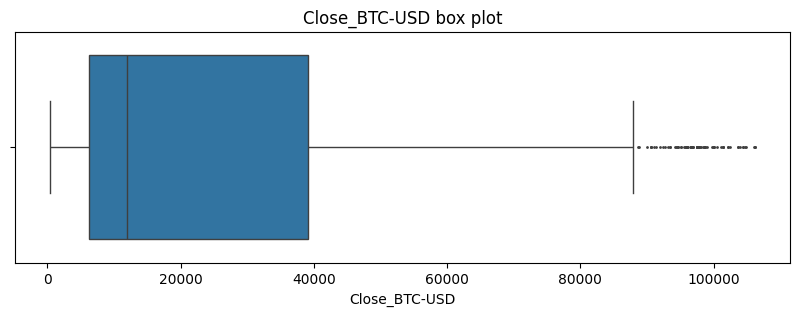

In [68]:
box('Close_BTC-USD')

In [88]:
def plot(col_str, **kwargs):

    plt.figure(figsize=(5,3))
    plt.plot(tsla_df.index, tsla_df[col_str], color='blue', label=col_str)
    plt.title(f'{col_str} line plot')
    plt.xlabel("Date")
    plt.ylabel(col_str)
    plt.legend()
    plt.grid();

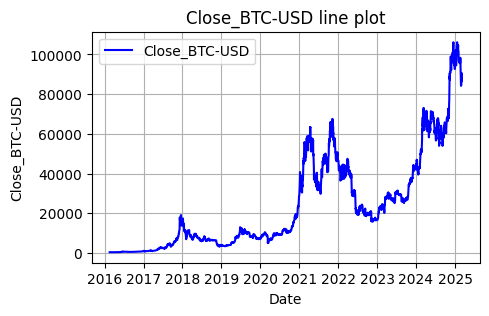

In [89]:
plot('Close_BTC-USD')

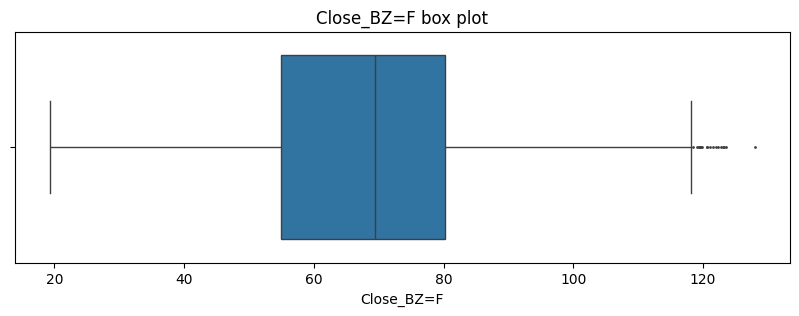

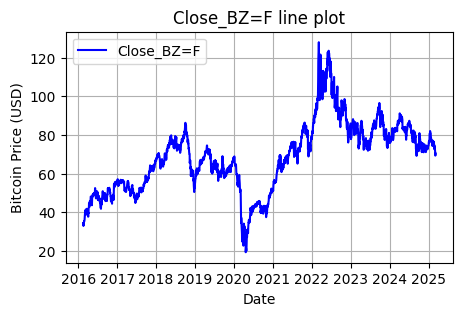

In [84]:
box('Close_BZ=F')
plot('Close_BZ=F')

Brent Crude Oil Futures is in line with other sources, no outliers.

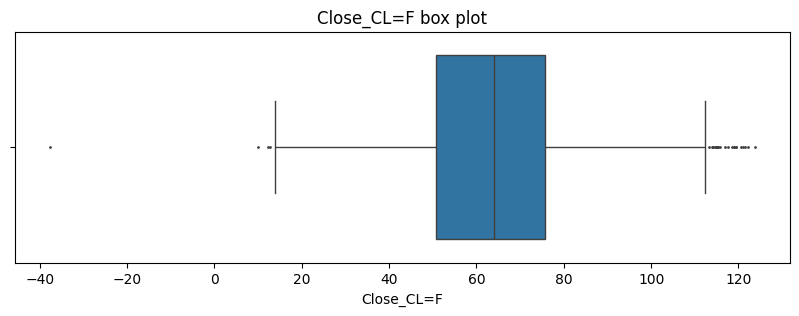

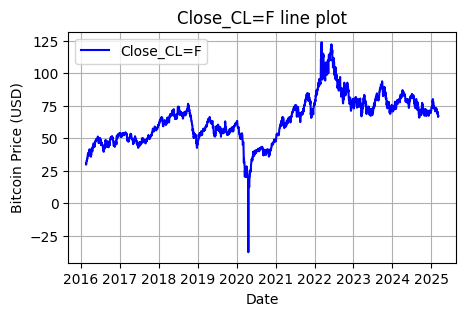

In [85]:
box('Close_CL=F')
plot('Close_CL=F')

WTI Crude Oil Futures trend follows with other sources, these are not outliers.

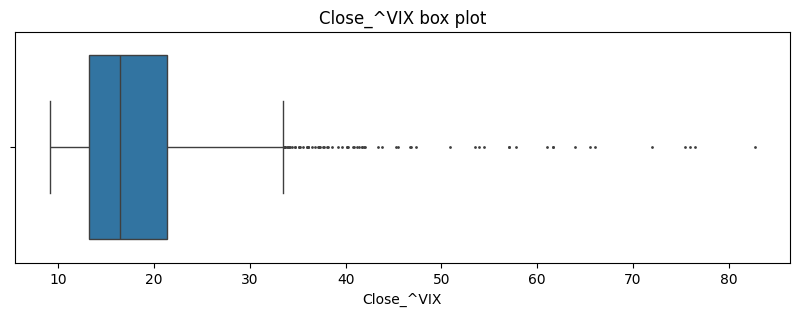

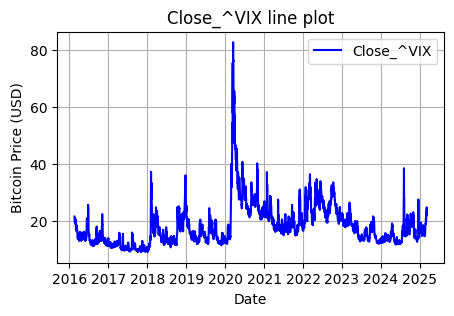

In [86]:
box("Close_^VIX")
plot("Close_^VIX")

VIX Index (CBOE Volatility Index) trend folows with other sources, these are not outliers.

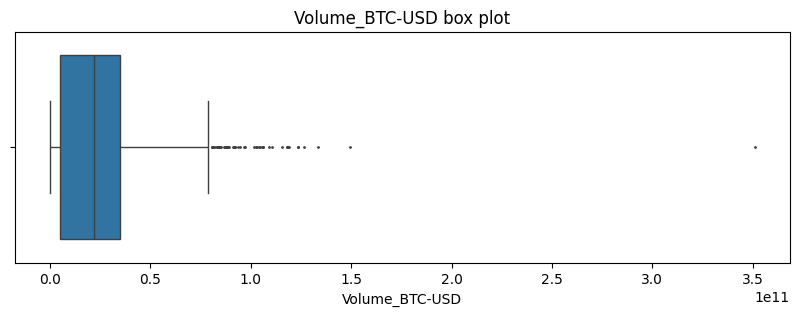

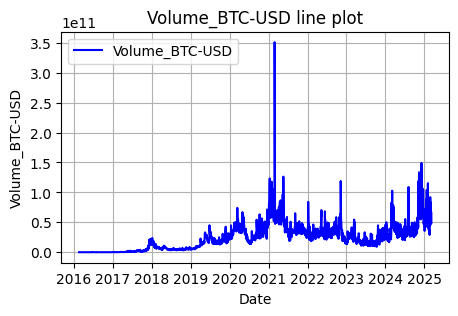

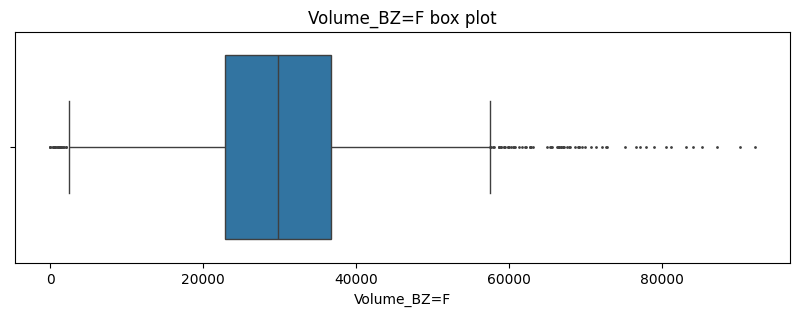

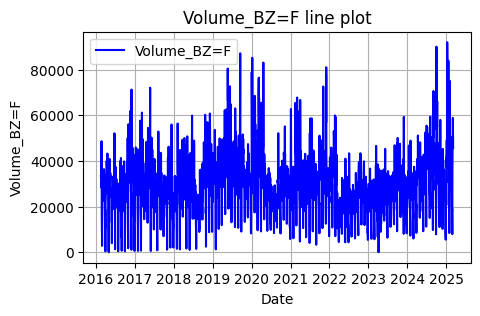

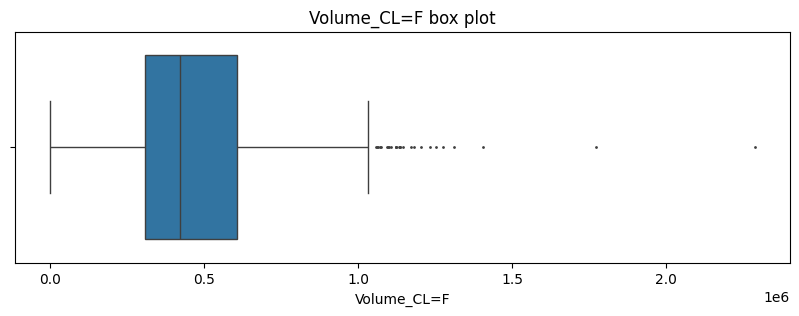

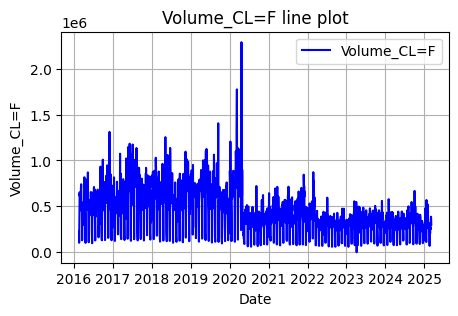

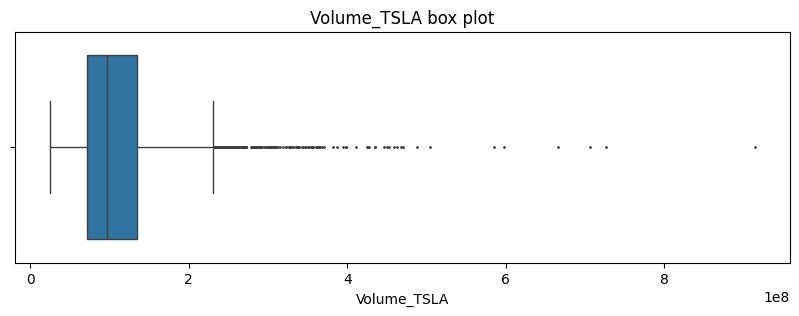

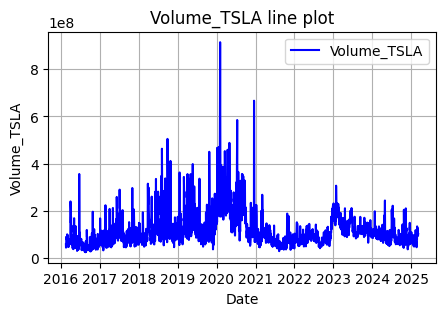

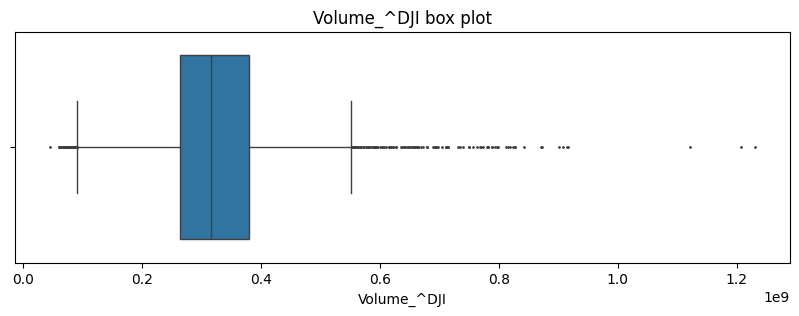

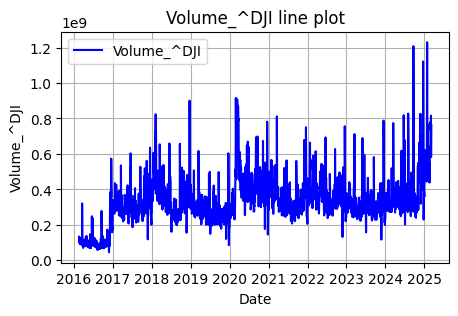

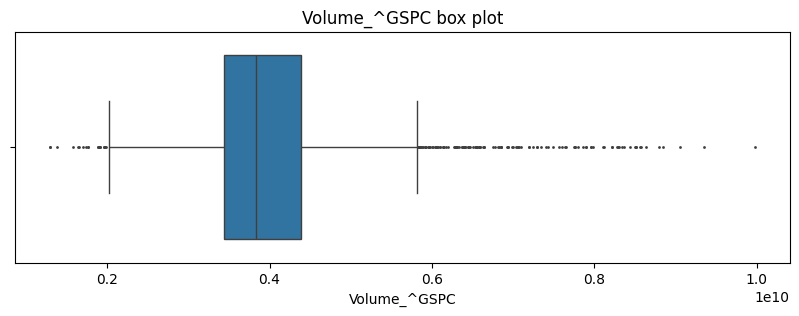

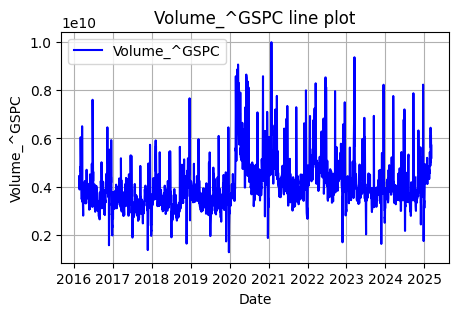

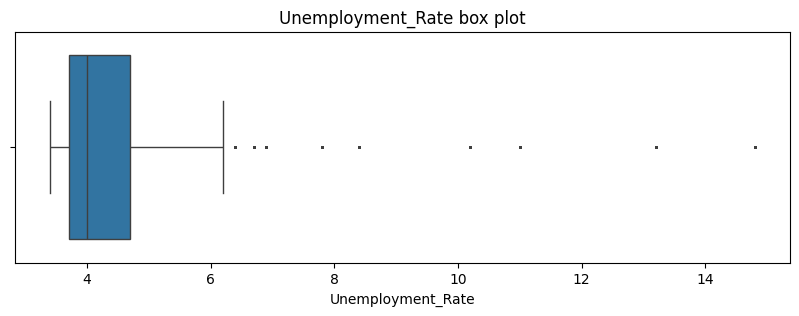

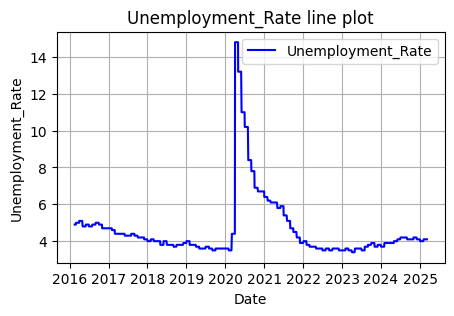

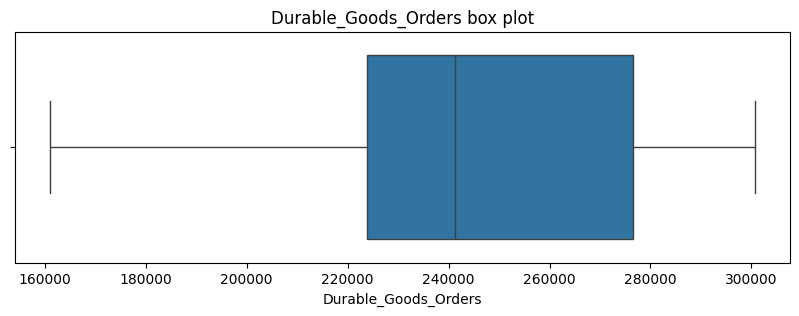

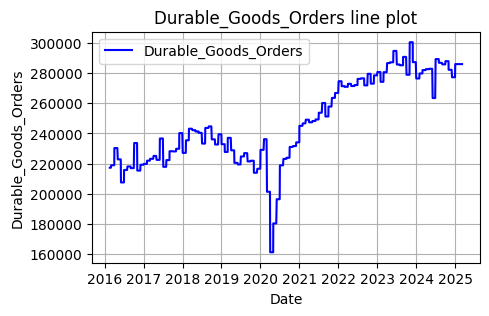

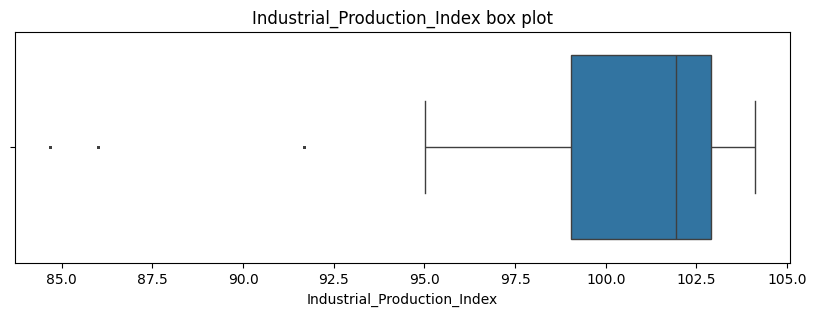

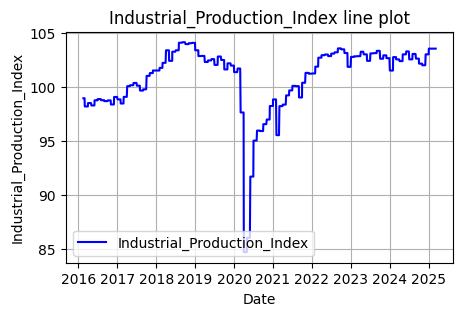

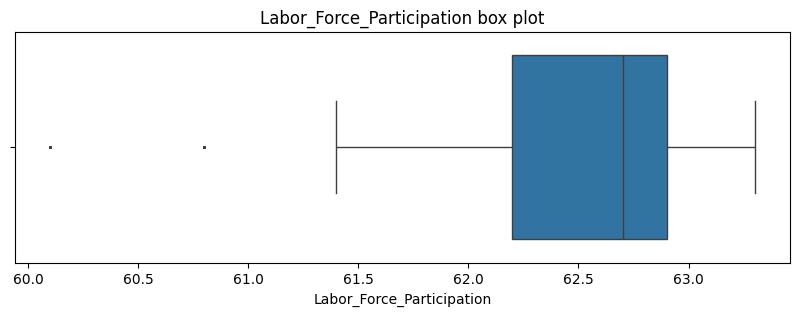

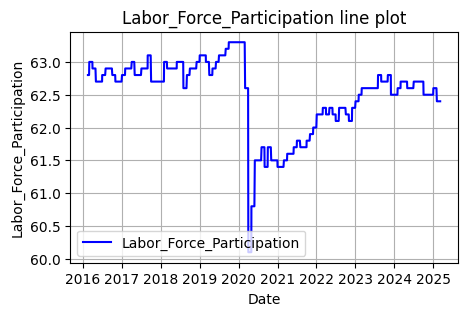

In [90]:
box('Volume_BTC-USD')
plot('Volume_BTC-USD')
box('Volume_BZ=F')
plot('Volume_BZ=F')
box('Volume_CL=F')
plot('Volume_CL=F')
box('Volume_TSLA')
plot('Volume_TSLA')
box('Volume_^DJI')
plot('Volume_^DJI')
box('Volume_^GSPC')
plot('Volume_^GSPC')
box('Unemployment_Rate')
plot('Unemployment_Rate')
box('Durable_Goods_Orders')
plot('Durable_Goods_Orders')
box('Industrial_Production_Index')
plot('Industrial_Production_Index')
box('Labor_Force_Participation')
plot('Labor_Force_Participation')

Economic outliers aligned to covid time.

In [45]:
# Setting Date back to index
tsla_df.set_index('Date', inplace=True)

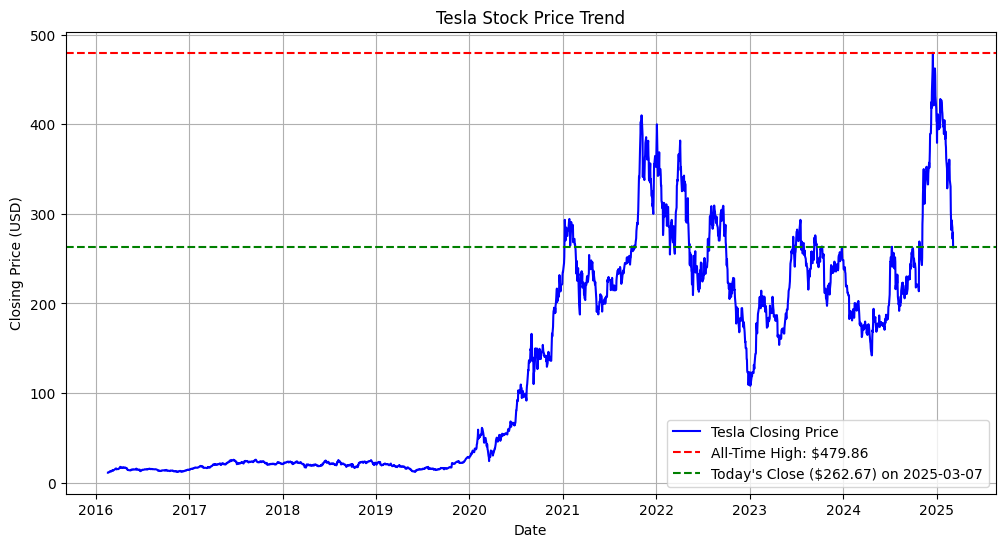

In [46]:
# All-Time High
all_time_high = tsla_df['Close_TSLA'].max()

# Latest price
todays_closing_price = tsla_df['Close_TSLA'].iloc[-1]
todays_date = tsla_df.index[-1].strftime('%Y-%m-%d') 

# Plot the Closing Price Trend
plt.figure(figsize=(12, 6))
plt.plot(tsla_df.index, tsla_df['Close_TSLA'], color='blue', label="Tesla Closing Price")

# Formatting the plot
plt.axhline(y=all_time_high, color='red', linestyle='--', label=f"All-Time High: ${all_time_high:.2f}")
plt.axhline(y=todays_closing_price, color='green', linestyle='--', label=f"Today's Close (${todays_closing_price:.2f}) on {todays_date}")
plt.title("Tesla Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid()

In [47]:
latest_close_prices = tsla_df['Close_TSLA'].iloc[-5:]
latest_close_prices

Date
2025-03-03    284.649994
2025-03-04    272.040009
2025-03-05    279.100006
2025-03-06    263.450012
2025-03-07    262.670013
Name: Close_TSLA, dtype: float64

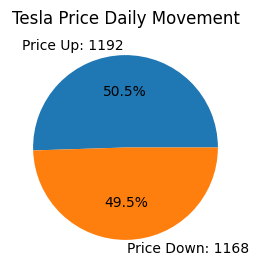

In [48]:
# Pie chart

fig = plt.figure(figsize=(3,3))
data=tsla_df['Label'].value_counts()
plt.pie(data, labels=[f"Price Up: {data.values[0]}", 
                     f"Price Down: {data.values[1]}"], 
                     autopct='%1.1f%%'
                     )
plt.title('Tesla Price Daily Movement');

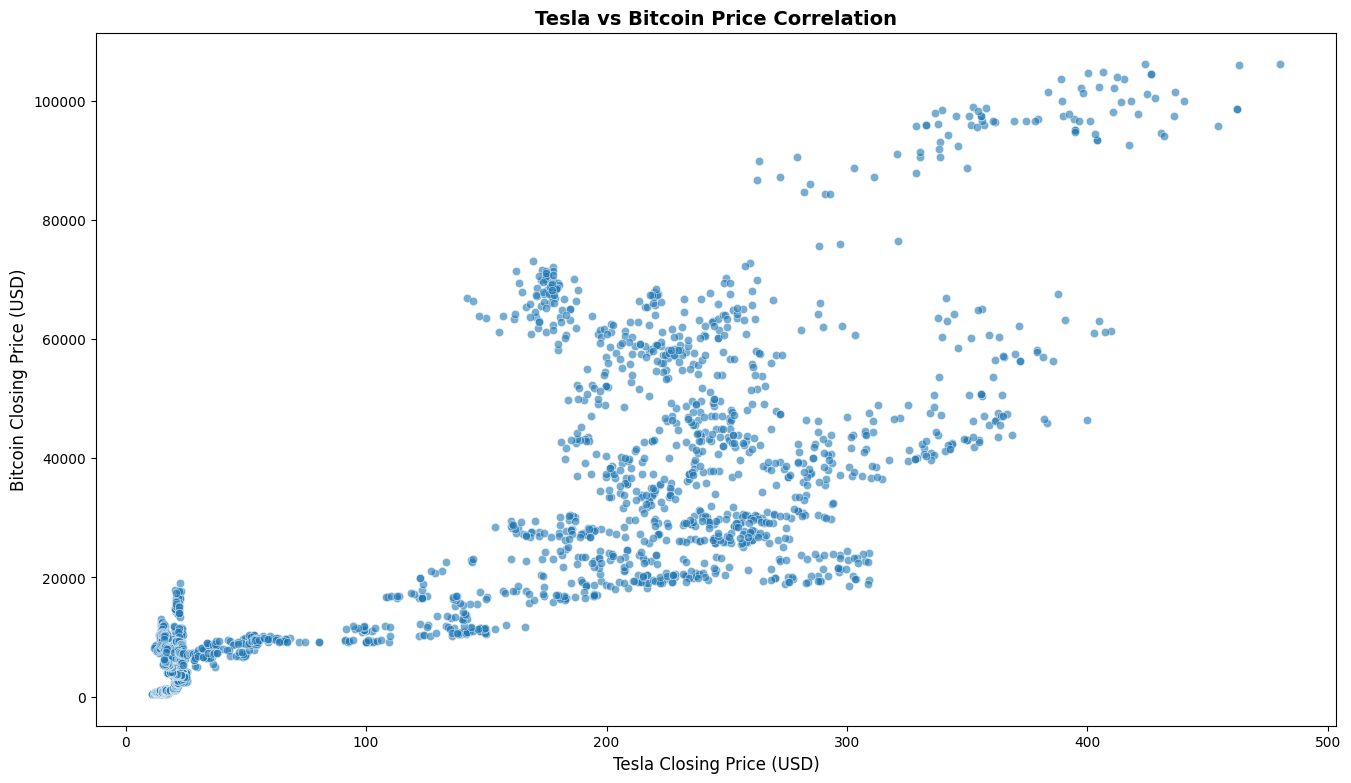

In [50]:
# Creating a scatterpplot
plt.figure(figsize=(16, 9))
sns.scatterplot(data=tsla_df, x='Close_TSLA', y='Close_BTC-USD', alpha=0.6)
plt.xlabel("Tesla Closing Price (USD)", fontsize=12)
plt.ylabel("Bitcoin Closing Price (USD)", fontsize=12)
plt.title("Tesla vs Bitcoin Price Correlation", fontsize=14, fontweight="bold");


Tesla and Bitcoin show some correlation

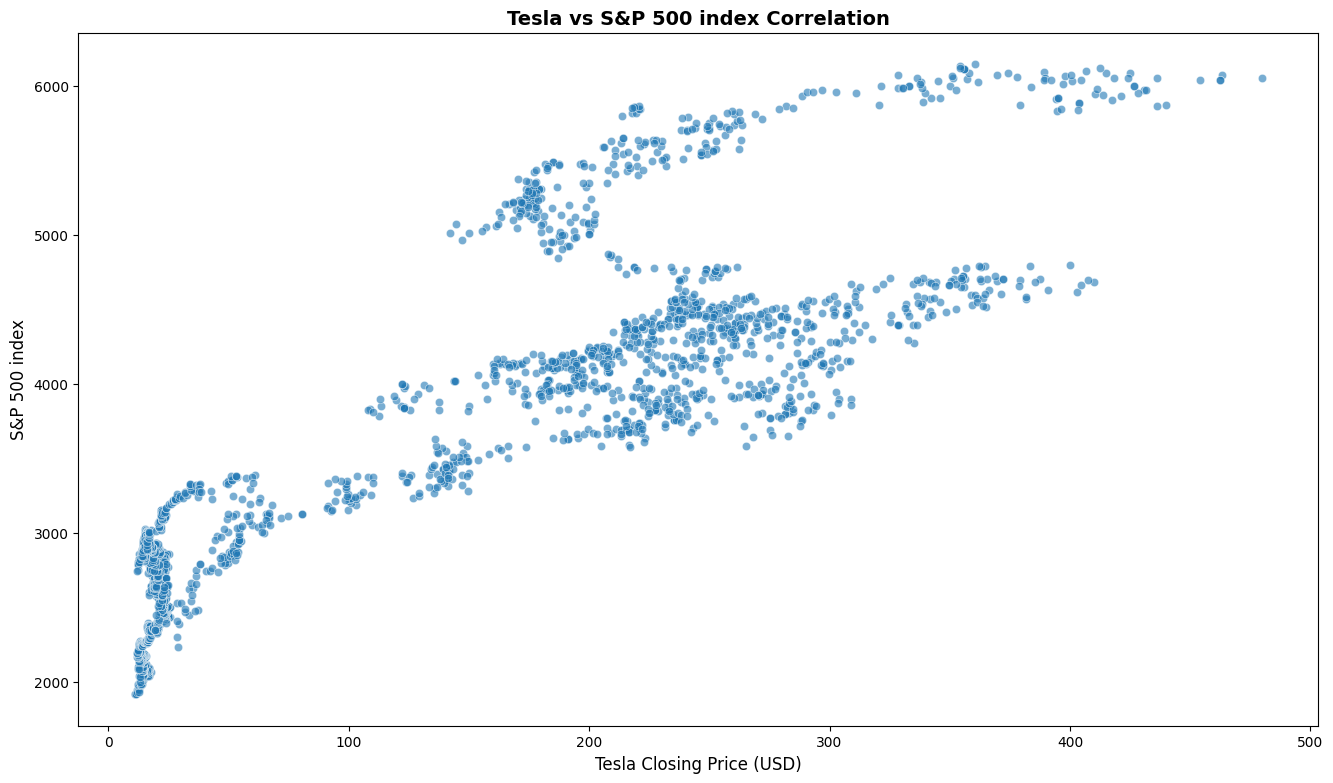

In [94]:
# Creating a scatterpplot
plt.figure(figsize=(16, 9))
sns.scatterplot(data=tsla_df, x='Close_TSLA', y='Close_^GSPC', alpha=0.6)
plt.xlabel("Tesla Closing Price (USD)", fontsize=12)
plt.ylabel("S&P 500 index", fontsize=12)
plt.title("Tesla vs S&P 500 index Correlation", fontsize=14, fontweight="bold");

Positive correlation, meaning Tesla’s stock price tends to rise when the S&P 500 index increases.

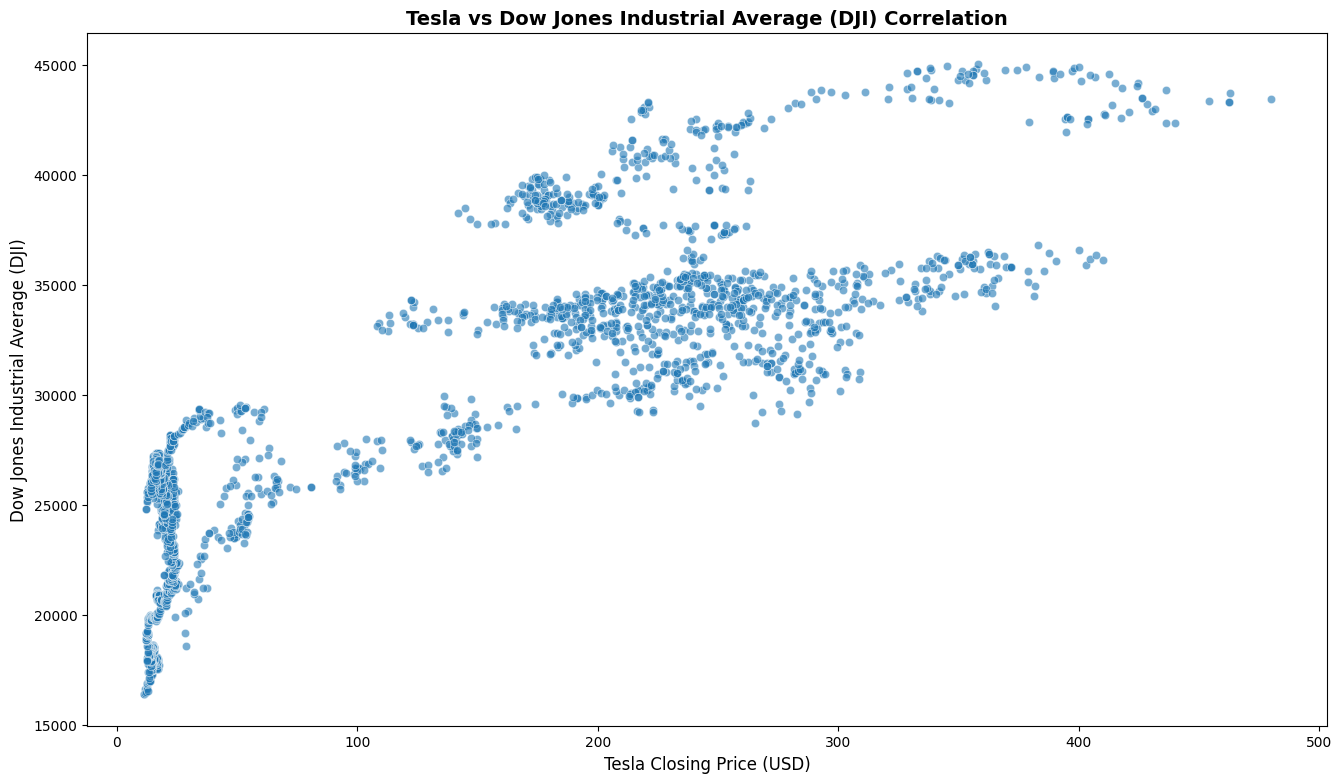

In [95]:
# Creating a scatterpplot
plt.figure(figsize=(16, 9))
sns.scatterplot(data=tsla_df, x='Close_TSLA', y='Close_^DJI', alpha=0.6)
plt.xlabel("Tesla Closing Price (USD)", fontsize=12)
plt.ylabel("Dow Jones Industrial Average (DJI)", fontsize=12)
plt.title("Tesla vs Dow Jones Industrial Average (DJI) Correlation", fontsize=14, fontweight="bold");

The upward trend suggests a positive correlation, meaning that as the DJI increases, Tesla’s stock price tends to rise as well.

In [96]:
# Function to plot histograms

def hist(col_str, median_txt=True, **kwargs):

    median=round(tsla_df[col_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=tsla_df[col_str], **kwargs)
    plt.axvline(median, color='red', linestyle='--')
    if median_txt==True:
        ax.text(0.25, 0.85, f'median={median}', color='red',
                ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{col_str} histogram');

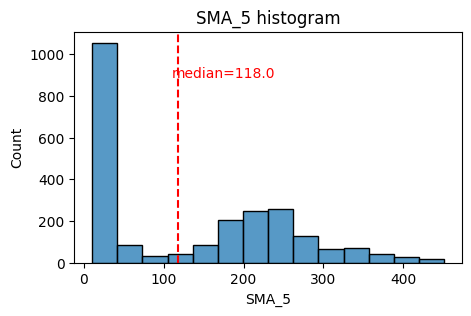

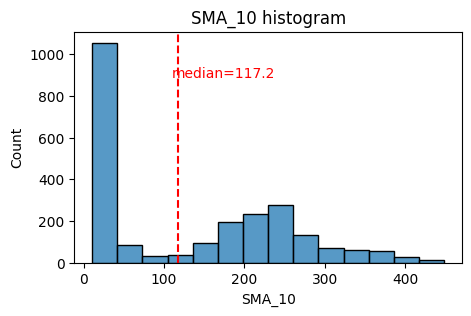

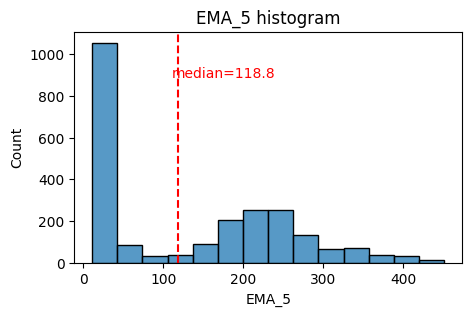

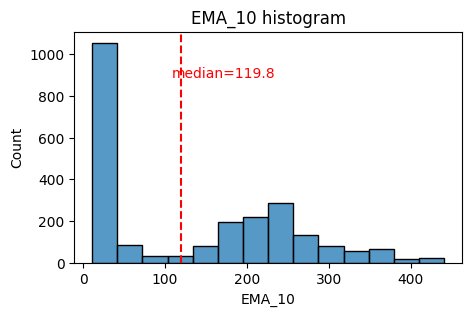

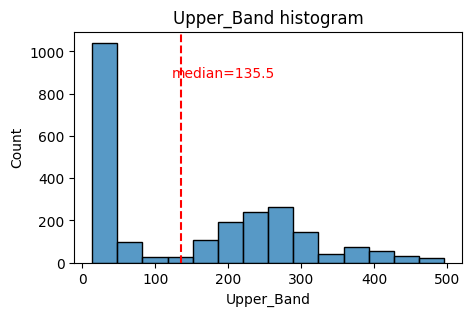

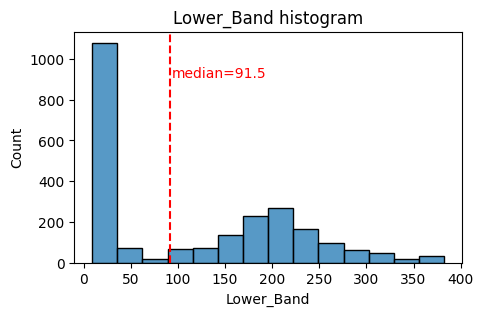

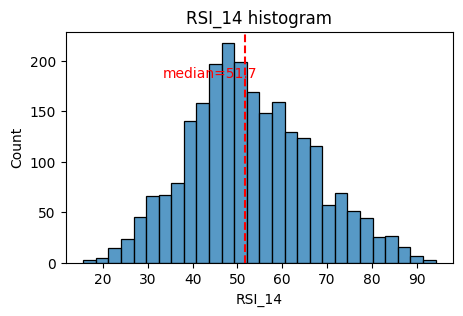

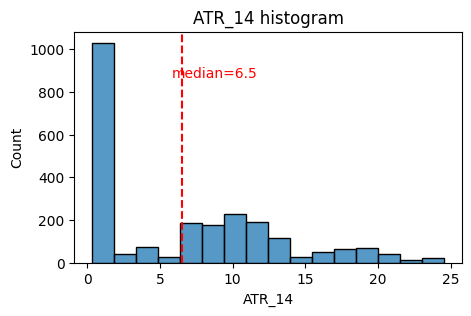

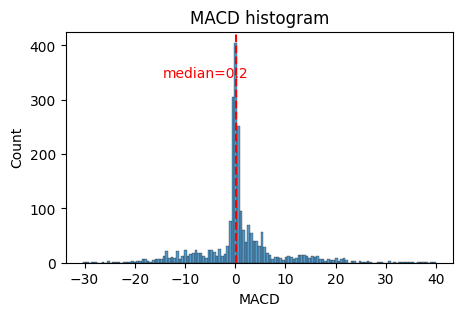

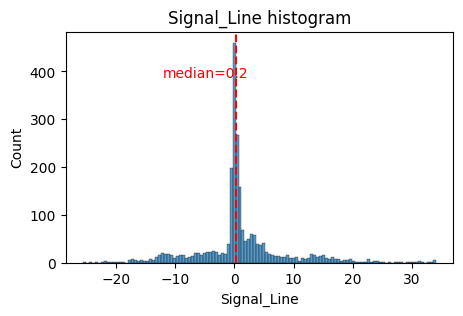

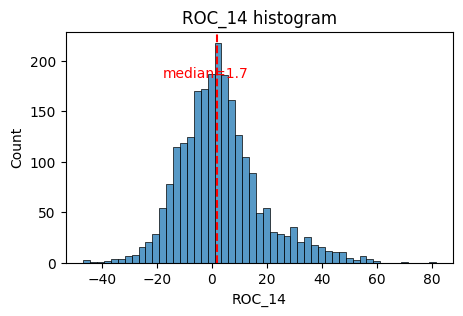

In [97]:
hist('SMA_5')
hist('SMA_10')
hist('EMA_5')
hist('EMA_10')
hist('Upper_Band')
hist('Lower_Band')
hist('RSI_14') 
hist('ATR_14')
hist('MACD')
hist('Signal_Line')
hist('ROC_14')

In [54]:
# Select features
selected_vars = ['Close_TSLA', 'Close_BTC-USD', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD','Volume_TSLA', 'Volume_BTC-USD']

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Related Variables')

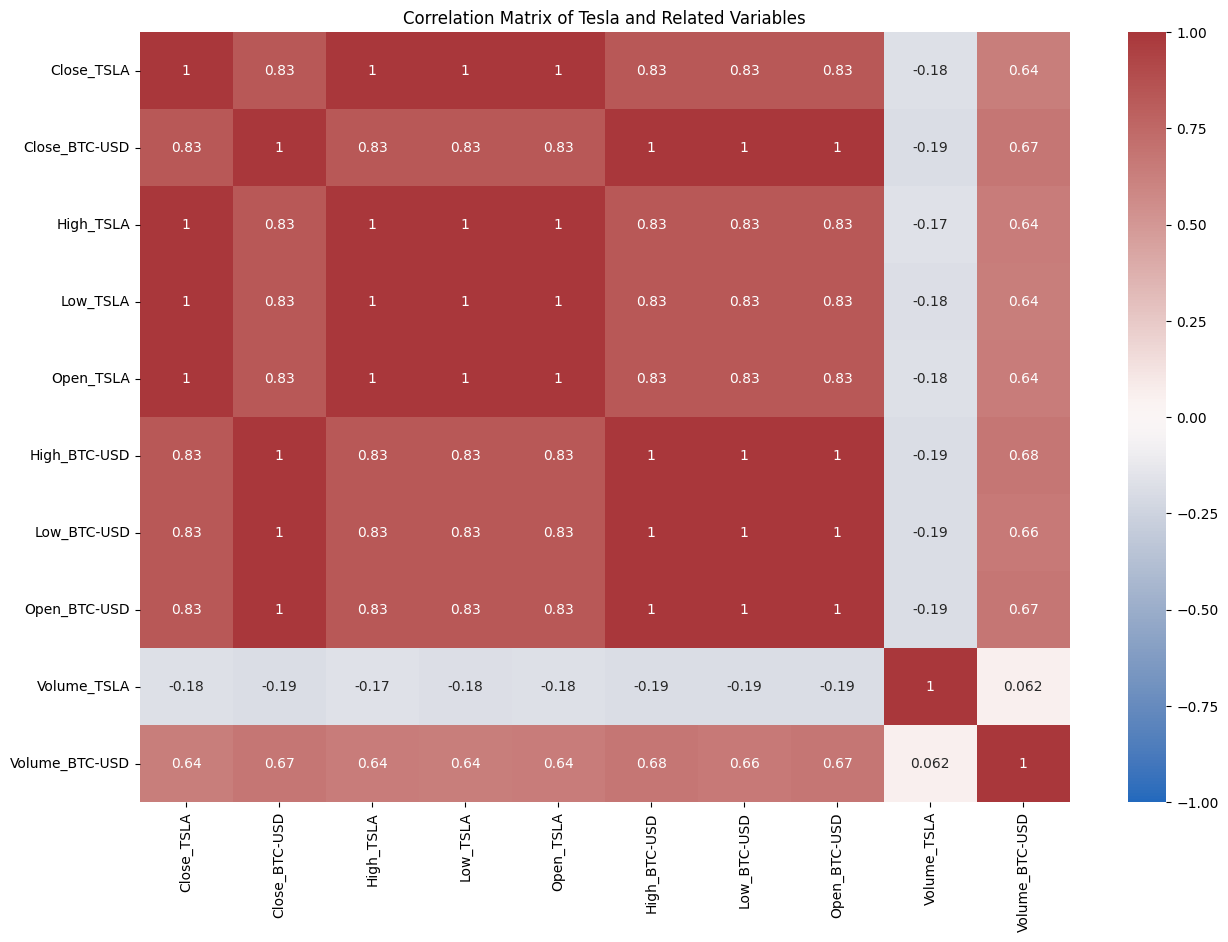

In [58]:
# Correlation matrix
corr_matrix = tsla_df[selected_vars].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Related Variables")

Highly correlated features that are showing the same thing. Dropping these features and keeping one from the dataset.

In [59]:
features_to_drop = ['High_TSLA', 'Low_TSLA', 'Open_TSLA', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD']

# Drop correlated features
tsla_df = tsla_df.drop(columns=features_to_drop)


In [60]:
# Select features
selected_vars = ['Close_TSLA', 'Close_BTC-USD', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'Upper_Band', 'Lower_Band','RSI_14', 'ATR_14', 'MACD', 'Signal_Line', 'ROC_14']

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Related Variables')

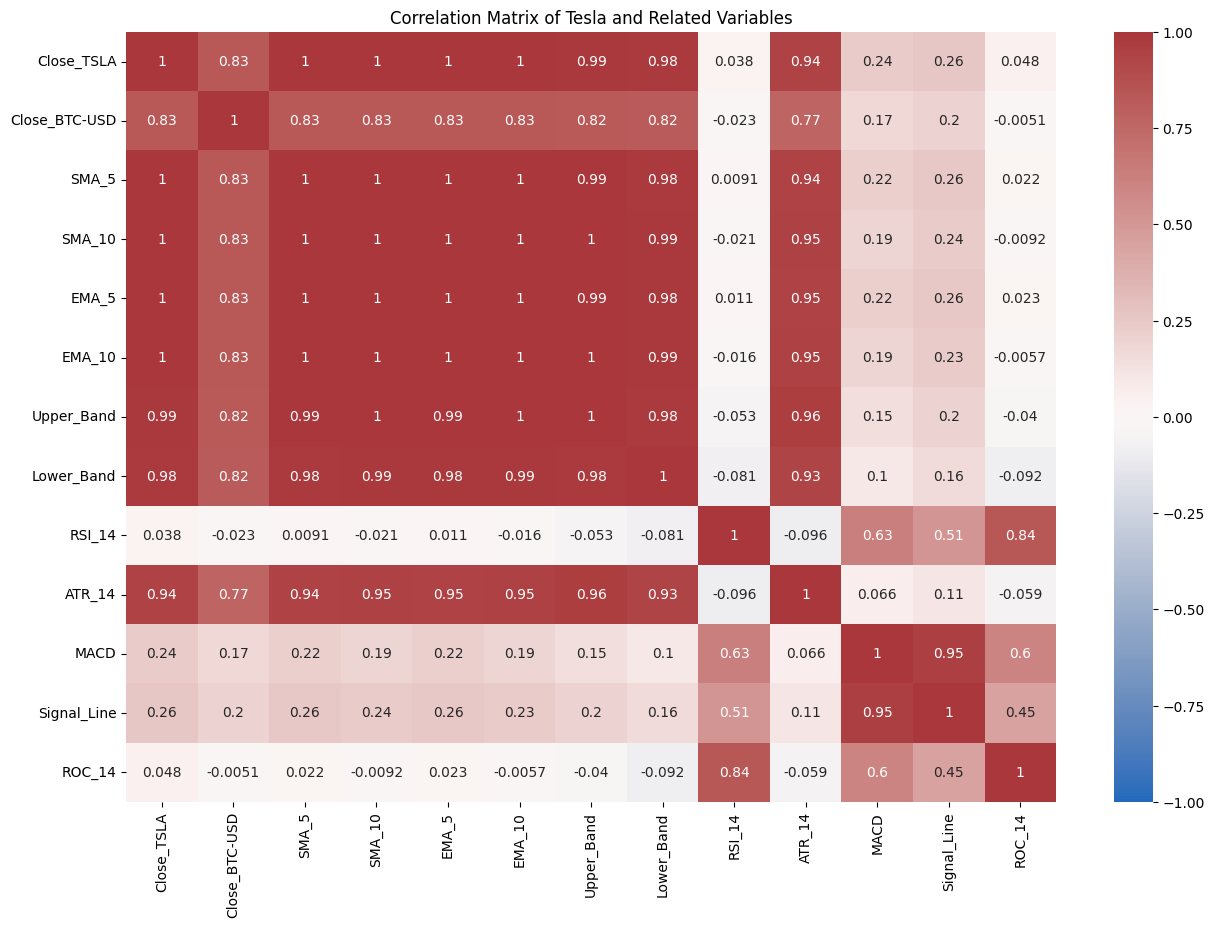

In [61]:
# Correlation matrix
corr_matrix = tsla_df[selected_vars].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Related Variables")

In [62]:
features_to_drop = [
    'SMA_5', 'EMA_5',  # Keep only 'SMA_10' and 'EMA_10'  
    'Upper_Band', 'Lower_Band',  # Redundant with SMA/EMA  
    'ATR_14',  # Highly correlated with Close_TSLA  
    'Signal_Line'  # MACD and Signal Line are redundant, keep MACD  
]

# Drop the selected features
tsla_df = tsla_df.drop(columns=features_to_drop)


In [47]:
# Get strong correlations (above 0.5 or below -0.5)
strong_corr = corr_matrix[(corr_matrix > 0.5) | (corr_matrix < -0.5)]
strong_corr

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,...,SMA_10,EMA_5,EMA_10,Upper_Band,Lower_Band,RSI_14,ATR_14,MACD,Signal_Line,ROC_14
Close_BTC-USD,1.000000,NaN,0.511943,0.829186,0.902962,0.931905,NaN,NaN,0.999556,NaN,...,0.828244,0.829411,0.829008,0.823976,0.819065,NaN,0.769098,NaN,NaN,NaN
Close_BZ=F,NaN,1.000000,0.989978,0.603092,0.640214,0.602316,0.631251,NaN,NaN,0.997980,...,0.610754,0.606907,0.612047,0.615130,0.622247,NaN,0.593159,NaN,NaN,NaN
Close_CL=F,0.511943,0.989978,1.000000,0.641769,0.650838,0.624329,0.609953,NaN,0.512051,0.987646,...,0.649733,0.645739,0.651012,0.653926,0.661250,NaN,0.630851,NaN,NaN,NaN
Close_TSLA,0.829186,0.603092,0.641769,1.000000,0.850522,0.875296,NaN,NaN,0.829240,0.605132,...,0.995311,0.998706,0.996582,0.988972,0.979529,NaN,0.940090,NaN,NaN,NaN
Close_^DJI,0.902962,0.640214,0.650838,0.850522,1.000000,0.987859,0.539729,NaN,0.902049,0.637620,...,0.849632,0.850730,0.850791,0.846261,0.842349,NaN,0.788409,NaN,NaN,NaN
Close_^GSPC,0.931905,0.602316,0.624329,0.875296,0.987859,1.000000,0.538312,NaN,0.930797,0.600190,...,0.873400,0.875082,0.874586,0.868986,0.864669,NaN,0.808126,NaN,NaN,NaN
Close_^TNX,NaN,0.631251,0.609953,NaN,0.539729,0.538312,1.000000,NaN,NaN,0.625436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close_^VIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High_BTC-USD,0.999556,NaN,0.512051,0.829240,0.902049,0.930797,NaN,NaN,1.000000,NaN,...,0.828762,0.829791,0.829488,0.824575,0.819663,NaN,0.769869,NaN,NaN,NaN
High_BZ=F,NaN,0.997980,0.987646,0.605132,0.637620,0.600190,0.625436,NaN,NaN,1.000000,...,0.613082,0.609128,0.614385,0.617856,0.624559,NaN,0.598482,NaN,NaN,NaN


In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = tsla_df.columns
vif_data["VIF"] = [variance_inflation_factor(tsla_df.values, i) for i in range(tsla_df.shape[1])]

# Display features with high VIF (above 5)
print(vif_data[vif_data["VIF"] > 5])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                        Feature            VIF
0                 Close_BTC-USD    3193.261695
1                    Close_BZ=F    4483.345862
2                    Close_CL=F    4397.160171
3                    Close_TSLA    6352.209936
4                    Close_^DJI   36535.039215
5                   Close_^GSPC   62774.709437
6                    Close_^TNX    4669.642234
7                    Close_^VIX     113.507478
8                  High_BTC-USD    4335.276145
9                     High_BZ=F    3973.456221
10                    High_CL=F    4264.430260
11                    High_TSLA    5158.807117
12                    High_^DJI   31701.989590
13                   High_^GSPC   53271.463596
14                    High_^TNX    6113.630370
15                    High_^VIX      92.320953
16                  Low_BTC-USD    2532.679344
17                     Low_BZ=F    4650.535015
18                     Low_CL=F    3968.872213
19                     Low_TSLA    4113.928963
20           

In [63]:
features_to_drop = ['High_BZ=F', 'High_CL=F', 'High_^DJI', 'High_^GSPC', 'High_^TNX', 'High_^VIX', 'Low_BZ=F', 'Low_CL=F', 'Low_^GSPC', 'Low_^TNX', 'Low_^VIX',
                    'Open_BZ=F', 'Open_CL=F', 'Open_^GSPC', 'Open_^TNX', 'Open_^VIX'
]

In [ ]:
# Drop the selected features
tsla_df = tsla_df.drop(columns=features_to_drop)

In [66]:
tsla_df

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,Low_^DJI,Open_^DJI,...,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Label,SMA_10,EMA_10,RSI_14,MACD,ROC_14
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-18,422.372986,34.279999,30.770000,11.118000,16413.429688,1917.829956,1.759,21.639999,16390.429688,16483.759766,...,0.38,217223.0,98.9232,62.8,0,10.304533,10.773436,42.006960,-0.841228,-12.777198
2016-02-19,420.785004,33.009998,29.639999,11.105333,16391.990234,1917.780029,1.748,20.530001,16278.000000,16410.960938,...,0.38,217223.0,98.9232,62.8,1,10.331067,10.833781,41.876770,-0.760521,-15.415858
2016-02-22,437.747986,34.689999,31.480000,11.849333,16620.660156,1945.500000,1.766,19.379999,16417.130859,16417.130859,...,0.38,217223.0,98.9232,62.8,1,10.529400,11.018427,51.403708,-0.629271,-2.757417
2016-02-23,420.735992,33.270000,31.870001,11.814000,16431.779297,1921.270020,1.745,20.980000,16403.529297,16610.390625,...,0.38,217223.0,98.9232,62.8,1,10.722467,11.163077,50.976381,-0.522087,2.150105
2016-02-24,424.954987,34.410000,32.150002,11.933333,16484.990234,1929.800049,1.742,20.719999,16165.860352,16418.839844,...,0.38,217223.0,98.9232,62.8,1,10.958000,11.303123,52.415195,-0.422642,2.093191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,84373.007812,73.180000,69.760002,292.980011,43840.910156,5954.500000,4.231,19.629999,43100.871094,43259.839844,...,4.33,286089.0,103.5110,62.4,1,326.176996,317.773282,29.401978,-25.020592,-16.465657
2025-03-03,86065.671875,71.620003,68.370003,284.649994,43191.238281,5849.720215,4.180,22.780001,42919.308594,43900.488281,...,4.33,286089.0,103.5110,62.4,0,319.057996,311.750866,27.711453,-26.228827,-13.348556
2025-03-04,87222.195312,71.040001,68.260002,272.040009,42520.988281,5778.149902,4.210,23.510000,42347.750000,43040.300781,...,4.33,286089.0,103.5110,62.4,1,310.850998,304.530710,25.336549,-27.882471,-19.158420
